In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


총 298개 모델, 298개 임계값 로드 완료.
▶️ 추론 시작: 슬라이딩 윈도우 수=216, 모델=298
▶️ 추론 중: 1/216
▶️ 추론 중: 2/216
▶️ 추론 중: 3/216
▶️ 추론 중: 4/216
▶️ 추론 중: 5/216
▶️ 추론 중: 6/216
▶️ 추론 중: 7/216
▶️ 추론 중: 8/216
▶️ 추론 중: 9/216
▶️ 추론 중: 10/216
▶️ 추론 중: 11/216
▶️ 추론 중: 12/216
▶️ 추론 중: 13/216
▶️ 추론 중: 14/216
▶️ 추론 중: 15/216
▶️ 추론 중: 16/216
▶️ 추론 중: 17/216
▶️ 추론 중: 18/216
▶️ 추론 중: 19/216
▶️ 추론 중: 20/216
▶️ 추론 중: 21/216
▶️ 추론 중: 22/216
▶️ 추론 중: 23/216
▶️ 추론 중: 24/216
▶️ 추론 중: 25/216
▶️ 추론 중: 26/216
▶️ 추론 중: 27/216
▶️ 추론 중: 28/216
▶️ 추론 중: 29/216
▶️ 추론 중: 30/216
▶️ 추론 중: 31/216
▶️ 추론 중: 32/216
▶️ 추론 중: 33/216
▶️ 추론 중: 34/216
▶️ 추론 중: 35/216
▶️ 추론 중: 36/216
▶️ 추론 중: 37/216
▶️ 추론 중: 38/216
▶️ 추론 중: 39/216
▶️ 추론 중: 40/216
▶️ 추론 중: 41/216
▶️ 추론 중: 42/216
▶️ 추론 중: 43/216
▶️ 추론 중: 44/216
▶️ 추론 중: 45/216
▶️ 추론 중: 46/216
▶️ 추론 중: 47/216
▶️ 추론 중: 48/216
▶️ 추론 중: 49/216
▶️ 추론 중: 50/216
▶️ 추론 중: 51/216
▶️ 추론 중: 52/216
▶️ 추론 중: 53/216
▶️ 추론 중: 54/216
▶️ 추론 중: 55/216
▶️ 추론 중: 56/216
▶️ 추론 중: 57/216
▶️ 추론 중: 58/216
▶️ 추론 중: 59/216
▶️ 추론

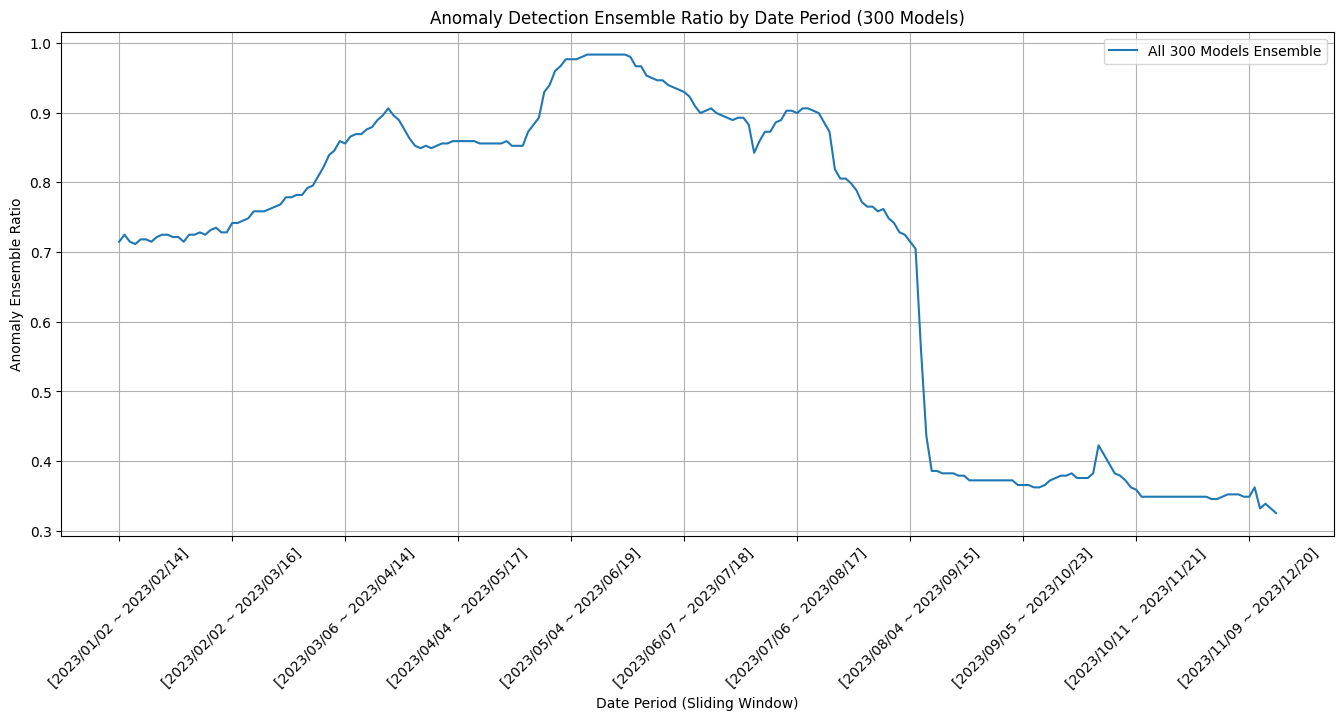

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import time
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ✅ LSTM-AE 클래스
class LSTMAutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = torch.nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.latent = torch.nn.Linear(hidden_dim, latent_dim)
        self.decoder_input = torch.nn.Linear(latent_dim, hidden_dim)
        self.decoder = torch.nn.LSTM(hidden_dim, input_dim, batch_first=True)
    def forward(self, x):
        _, (h_n, _) = self.encoder(x)
        z = self.latent(h_n[-1])
        dec_input = self.decoder_input(z).unsqueeze(1).repeat(1, x.size(1), 1)
        out, _ = self.decoder(dec_input)
        return out

features = ['종가', '대비', '등락률', '시가', '고가', '저가', '거래량', '거래대금', '시가총액', '상장주식수']
window_size = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ensemble_weight_dir = "/content/drive/MyDrive/LSTMAE_PROJECT/ensemble_weights"
ensemble_threshold_dir = "/content/drive/MyDrive/LSTMAE_PROJECT/ensemble_thresholds"

# 1. 300개 모델 가중치/임계값 로딩
all_weights = {}
all_thresholds = {}
for set_idx in range(1, 11):
    weight_file = f"{ensemble_weight_dir}/ensemble_weights_set{set_idx}.pt"
    threshold_file = f"{ensemble_threshold_dir}/ensemble_thresholds_set{set_idx}.csv"
    weights_dict = torch.load(weight_file, map_location=device)
    threshold_df = pd.read_csv(threshold_file)
    threshold_map = dict(zip(threshold_df['종목명'], threshold_df['임계값']))
    for stock_name in weights_dict:
        all_weights[stock_name] = weights_dict[stock_name]
        all_thresholds[stock_name] = threshold_map.get(stock_name, None)
print(f"총 {len(all_weights)}개 모델, {len(all_thresholds)}개 임계값 로드 완료.")

# 2. 조작 데이터 준비
data_path = "/content/drive/MyDrive/LSTMAE_PROJECT/anomaly_data.csv"
df_input = pd.read_csv(data_path, encoding='cp949')
df_input = df_input[features]
assert len(df_input) >= window_size, "입력 데이터는 최소 30일 이상 필요"

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_input.values)
def create_sequences(data, window_size):
    return np.array([data[i:i+window_size] for i in range(len(data)-window_size)])
sequences = create_sequences(scaled_data, window_size)

df_date = pd.read_csv(data_path, encoding='cp949')
df_date = df_date['일자'][::-1]
date_ranges = [
    f"[{df_date.iloc[i]} ~ {df_date.iloc[i+window_size-1]}]"
    for i in range(len(df_input) - window_size)
]

# 3. 추론 시간 측정
import gc
anomaly_ratios = []
stock_names = list(all_weights.keys())

print(f"▶️ 추론 시작: 슬라이딩 윈도우 수={len(sequences)}, 모델={len(stock_names)}")

start_time = time.time()

for i in range(len(sequences)):
    print(f"▶️ 추론 중: {i+1}/{len(sequences)}")
    input_tensor = torch.tensor(sequences[i].reshape(1, window_size, len(features)), dtype=torch.float32).to(device)
    num_total, num_anomalies = 0, 0
    for stock_name in stock_names:
        threshold = all_thresholds.get(stock_name, None)
        if threshold is None:
            continue
        try:
            model = LSTMAutoEncoder(input_dim=len(features), hidden_dim=64, latent_dim=16).to(device)
            model.load_state_dict(all_weights[stock_name])
            model.eval()
            with torch.no_grad():
                output = model(input_tensor)
                recon_error = torch.mean((input_tensor - output) ** 2).item()
            if recon_error > threshold:
                num_anomalies += 1
            num_total += 1
            del model
            gc.collect()
        except Exception as e:
            continue
    ratio = num_anomalies / num_total if num_total > 0 else 0
    anomaly_ratios.append(ratio)

end_time = time.time()
elapsed = end_time - start_time
mean_per_window = elapsed / len(sequences)

print(f"✅ 전체 추론 소요 시간: {elapsed:.2f}초")
print(f"✅ 윈도우 1개당 평균 추론 시간: {mean_per_window:.3f}초")

# 4. 라인그래프
plt.figure(figsize=(14, 6))
plt.plot(date_ranges, anomaly_ratios, label="All 300 Models Ensemble")
plt.xlabel("Date Period (Sliding Window)")
plt.ylabel("Anomaly Ensemble Ratio")
plt.title("Anomaly Detection Ensemble Ratio by Date Period (300 Models)")
plt.legend()
plt.grid(True)
plt.tight_layout()
step = max(1, len(date_ranges)//10)
plt.xticks(
    ticks=range(0, len(date_ranges), step),
    labels=[date_ranges[i] for i in range(0, len(date_ranges), step)],
    rotation=45
)
plt.show()
